In [202]:
import bec4fit
import bec4lib
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from scipy.sparse.linalg import bicgstab

In [11]:
imgs = np.load("imgs.npz.npy")
camInfo = np.load("camInfo.npz.npy",allow_pickle=True)

In [203]:
dat = bec4lib.BEC4image(imgs,camInfo)
dat.absorptiveKinetic(knifeEdge=5,bottomEdge=15,doPCA=True,PCA_window=None,isFastKinetic=False)
absImg_pca = dat.absImg

In [204]:
sample = convolve2d(dat.absImg[0],np.ones((5,5)),mode='same')
xmi,ymi = np.unravel_index(np.argmax(sample),shape=sample.shape)

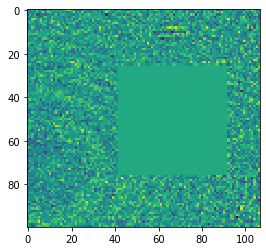

In [223]:
mask = np.ones(shape=dat.absImg[0].shape)
ws = 25
mask[xmi-ws:xmi+ws,ymi-ws:ymi+ws] = 0
plt.imshow(mask*dat.absImg[0])

In [224]:
dat.absorptiveKinetic(knifeEdge=5,bottomEdge=15,doPCA=False,PCA_window=None,isFastKinetic=False)
pwa = dat.pwa
pwoa = dat.pwoa
dark = dat.dark

edge = 5
d = 1
basis_dim = dat.shotsN * ((2*d + 1)**2)
basis_vec_shape = (mask.shape[0]-2*edge,mask.shape[1]-2*edge)
basis = np.zeros((basis_dim,*basis_vec_shape))
basis_masked = np.zeros_like(basis)
pwa_c =  np.zeros((dat.shotsN,*basis_vec_shape))
pwa_c_masked = np.zeros_like(pwa_c)
pwoa_masked = np.zeros_like(pwa_c)
dark_c = np.zeros_like(pwa_c)
for i in range(dat.shotsN):
    idx = 0
    for j in range(-d,d+1):
        for k in range(-d,d+1):
            pwoa_e = np.roll(np.roll(pwoa[i],j,axis=0),k,axis=1)
            #dark_e = np.roll(np.roll(dark[i],j,axis=0),k,axis=1)
            masked = (pwoa_e)*mask
            basis[i*((2*d+1)**2)+idx,:,:] = (pwoa_e)[edge:-edge,edge:-edge]
            basis_masked[i*((2*d+1)**2)+idx,:,:] = masked[edge:-edge,edge:-edge]
            idx += 1
    pwa_c[i] = (pwa[i])[edge:-edge,edge:-edge]
    dark_c[i] = (dark[i])[edge:-edge,edge:-edge]
    pwa_c_masked[i] = ((pwa[i])*mask)[edge:-edge,edge:-edge]
    pwoa_masked[i] = ((pwoa[i])*mask)[edge:-edge,edge:-edge]

C = (basis_masked.reshape(basis_dim,-1))@(basis_masked.reshape(basis_dim,-1)).T
P = (pwa_c_masked.reshape(dat.shotsN,-1))@(basis_masked.reshape(basis_dim,-1)).T


In [225]:
beta = np.zeros((dat.shotsN,basis_dim))
for i in range(dat.shotsN):
    beta[i],_ = bicgstab(C,P[i],tol=1e-14)

In [259]:
pwoa_cor = (beta@basis.reshape(basis_dim,-1))
pwoa_cor = pwoa_cor.reshape(-1,*basis_vec_shape)

pwa_clip = pwa[:,edge:-edge,edge:-edge]
dark_clip = dark[:,edge:-edge,edge:-edge]

absImg_cor = -np.log(np.maximum((pwa_clip-dark_clip)/(pwoa_cor-dark_clip),0.002))

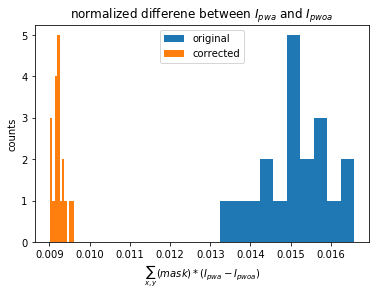

In [265]:
diff_original = np.sum(np.abs(pwoa_masked-pwa_c_masked),axis=(1,2)) /np.sum(np.abs(pwoa_masked+pwa_c_masked)/2,axis=(1,2))
diff_corrected = np.array([np.sum(np.abs(pwoa_cor[i]*mask[edge:-edge,edge:-edge] - pwa_c_masked[i])) for i in range(dat.shotsN)])/np.array([np.sum(np.abs(pwoa_cor[i]*mask[edge:-edge,edge:-edge] + pwa_c_masked[i]))/2 for i in range(dat.shotsN)])

plt.hist(diff_original,label="original")
plt.hist(diff_corrected,label="corrected")
plt.ylabel("counts")
plt.xlabel("$\sum_{x,y}(mask)*(I_{pwa}-I_{pwoa})$")
plt.title("normalized differene between $I_{pwa}$ and $I_{pwoa}$")
plt.legend()

In [240]:
i

16

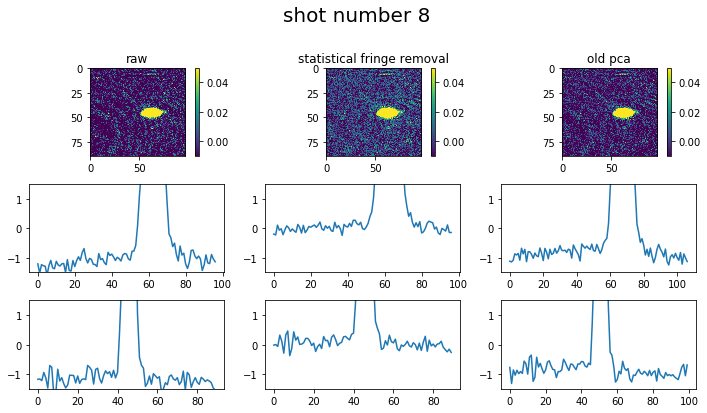

In [257]:
i = np.random.randint(0,dat.shotsN)

fig = plt.figure(figsize=(10,6))
fig.add_subplot(3,3,1)
plt.imshow(dat.absImg[i][edge:-edge,edge:-edge])
plt.colorbar()
plt.clim([-0.01,0.05])
plt.title("raw")
fig.add_subplot(3,3,2)
plt.imshow(absImg_cor[i])
plt.clim([-0.01,0.05])
plt.colorbar()
plt.title("statistical fringe removal")
fig.add_subplot(3,3,3)
plt.imshow(absImg_pca[i][edge:-edge,edge:-edge])
plt.clim([-0.01,0.05])
plt.title("old pca")
plt.colorbar()

fig.add_subplot(3,3,4)
plt.plot(np.sum(dat.absImg[i][edge:-edge,edge:-edge],axis=0))
plt.ylim([-1.5,1.5])
fig.add_subplot(3,3,5)
plt.plot(np.sum(absImg_cor[i],axis=0))
plt.ylim([-1.5,1.5])
fig.add_subplot(3,3,6)
plt.plot(np.sum(absImg_pca[i],axis=0))
plt.ylim([-1.5,1.5])

fig.add_subplot(3,3,7)
plt.plot(np.sum(dat.absImg[i][edge:-edge,edge:-edge],axis=1))
plt.ylim([-1.5,1.5])
fig.add_subplot(3,3,8)
plt.plot(np.sum(absImg_cor[i],axis=1))
plt.ylim([-1.5,1.5])
fig.add_subplot(3,3,9)
plt.plot(np.sum(absImg_pca[i],axis=1))
plt.ylim([-1.5,1.5])


fig.suptitle(f"shot number {i}",fontsize=20)
fig.tight_layout(rect=[0, 0.03, 1, 0.90])